In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# Importing important libraries

In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import string
import html
import re

# **LOADING THE DATA**

In [3]:
train_df = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
test_df = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")
train_df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


# **EDA ON THE DATASET**

In [4]:
#check the shape of Dataset
print(f"""shape of train data : {train_df.shape}
shape of test data : {test_df.shape}""")

#check the datatype of each column
print(train_df.info())

shape of train data : (13636, 15)
shape of test data : (4546, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(

 **KEY STATISTICS AND RELATIONSHIPS IN THE DATA**

In [5]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,13636.0,1.210853e+02,1.169956e+02,0.000000e+00,4.500000e+01,9.100000e+01,1.480000e+02,7.240000e+02
RecipeNumber,13636.0,3.862438e+01,2.967235e+01,1.000000e+00,1.200000e+01,3.300000e+01,6.300000e+01,1.000000e+02
RecipeCode,13636.0,2.178599e+04,2.388319e+04,3.860000e+02,6.504000e+03,1.460000e+04,3.312100e+04,1.917750e+05
UserReputation,13636.0,2.160311e+00,1.008642e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.100000e+02
CreationTimestamp,13636.0,1.623713e+09,5.444020e+06,1.613035e+09,1.622717e+09,1.622718e+09,1.622718e+09,1.665756e+09
ReplyCount,13636.0,1.452039e-02,1.373234e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
ThumbsUpCount,13636.0,1.098269e+00,4.166487e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+01
ThumbsDownCount,13636.0,5.437078e-01,3.265660e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.260000e+02
Rating,13636.0,4.288721e+00,1.544839e+00,0.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
BestScore,13636.0,1.531279e+02,1.409869e+02,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,9.460000e+02


**KEY POINTS**


1. Count:

* There are 13,636 observations for each variable, indicating a reasonably large dataset.
* There are 14 features in the dataset.

2. Mean:

* For "ID," "RecipeNumber," "RecipeCode," and "CreationTimestamp," the means are relatively high, suggesting that these variables may have a wide range of values.
* The mean for "UserReputation" is around 2.16, indicating that the average user reputation score is relatively low.
* The mean for "ReplyCount," "ThumbsUpCount," and "ThumbsDownCount" are very close to zero, suggesting that the majority of observations have no replies, thumbs up, or thumbs down.
* The mean rating is approximately 4.29, indicating that the average rating is relatively high.

3. Standard Deviation (Std):

* Variables such as "ID," "RecipeNumber," "RecipeCode," and "CreationTimestamp" have relatively high standard deviations, indicating a wide spread of values.
* "UserReputation" has a standard deviation of approximately 10.09, indicating a wide variation in user reputation scores.
* Other variables such as "ReplyCount," "ThumbsUpCount," and "ThumbsDownCount" have very low standard deviations, suggesting that most observations have very few replies, thumbs up, or thumbs down.

4. Min, Max, Quartiles (25%, 50%, 75%):

* The quartiles for "UserReputation" indicate that the majority of users have a reputation score of 1.
* The quartiles for "Rating" show that the majority of ratings are 5, as the 25th, 50th, and 75th percentiles are all 5.

In [6]:
#separating Target column from the dataframe
target = train_df["Rating"]
features = list(train_df.drop("Rating", axis=1).columns.values)
print("FeaturesList:", features)
print("Total Features:", len(features))

FeaturesList: ['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID', 'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Recipe_Review']
Total Features: 14


**DATA VISUALISATION**

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'RecipeNumber'}>,
        <Axes: title={'center': 'RecipeCode'}>],
       [<Axes: title={'center': 'UserReputation'}>,
        <Axes: title={'center': 'CreationTimestamp'}>,
        <Axes: title={'center': 'ReplyCount'}>],
       [<Axes: title={'center': 'ThumbsUpCount'}>,
        <Axes: title={'center': 'ThumbsDownCount'}>,
        <Axes: title={'center': 'Rating'}>],
       [<Axes: title={'center': 'BestScore'}>, <Axes: >, <Axes: >]],
      dtype=object)

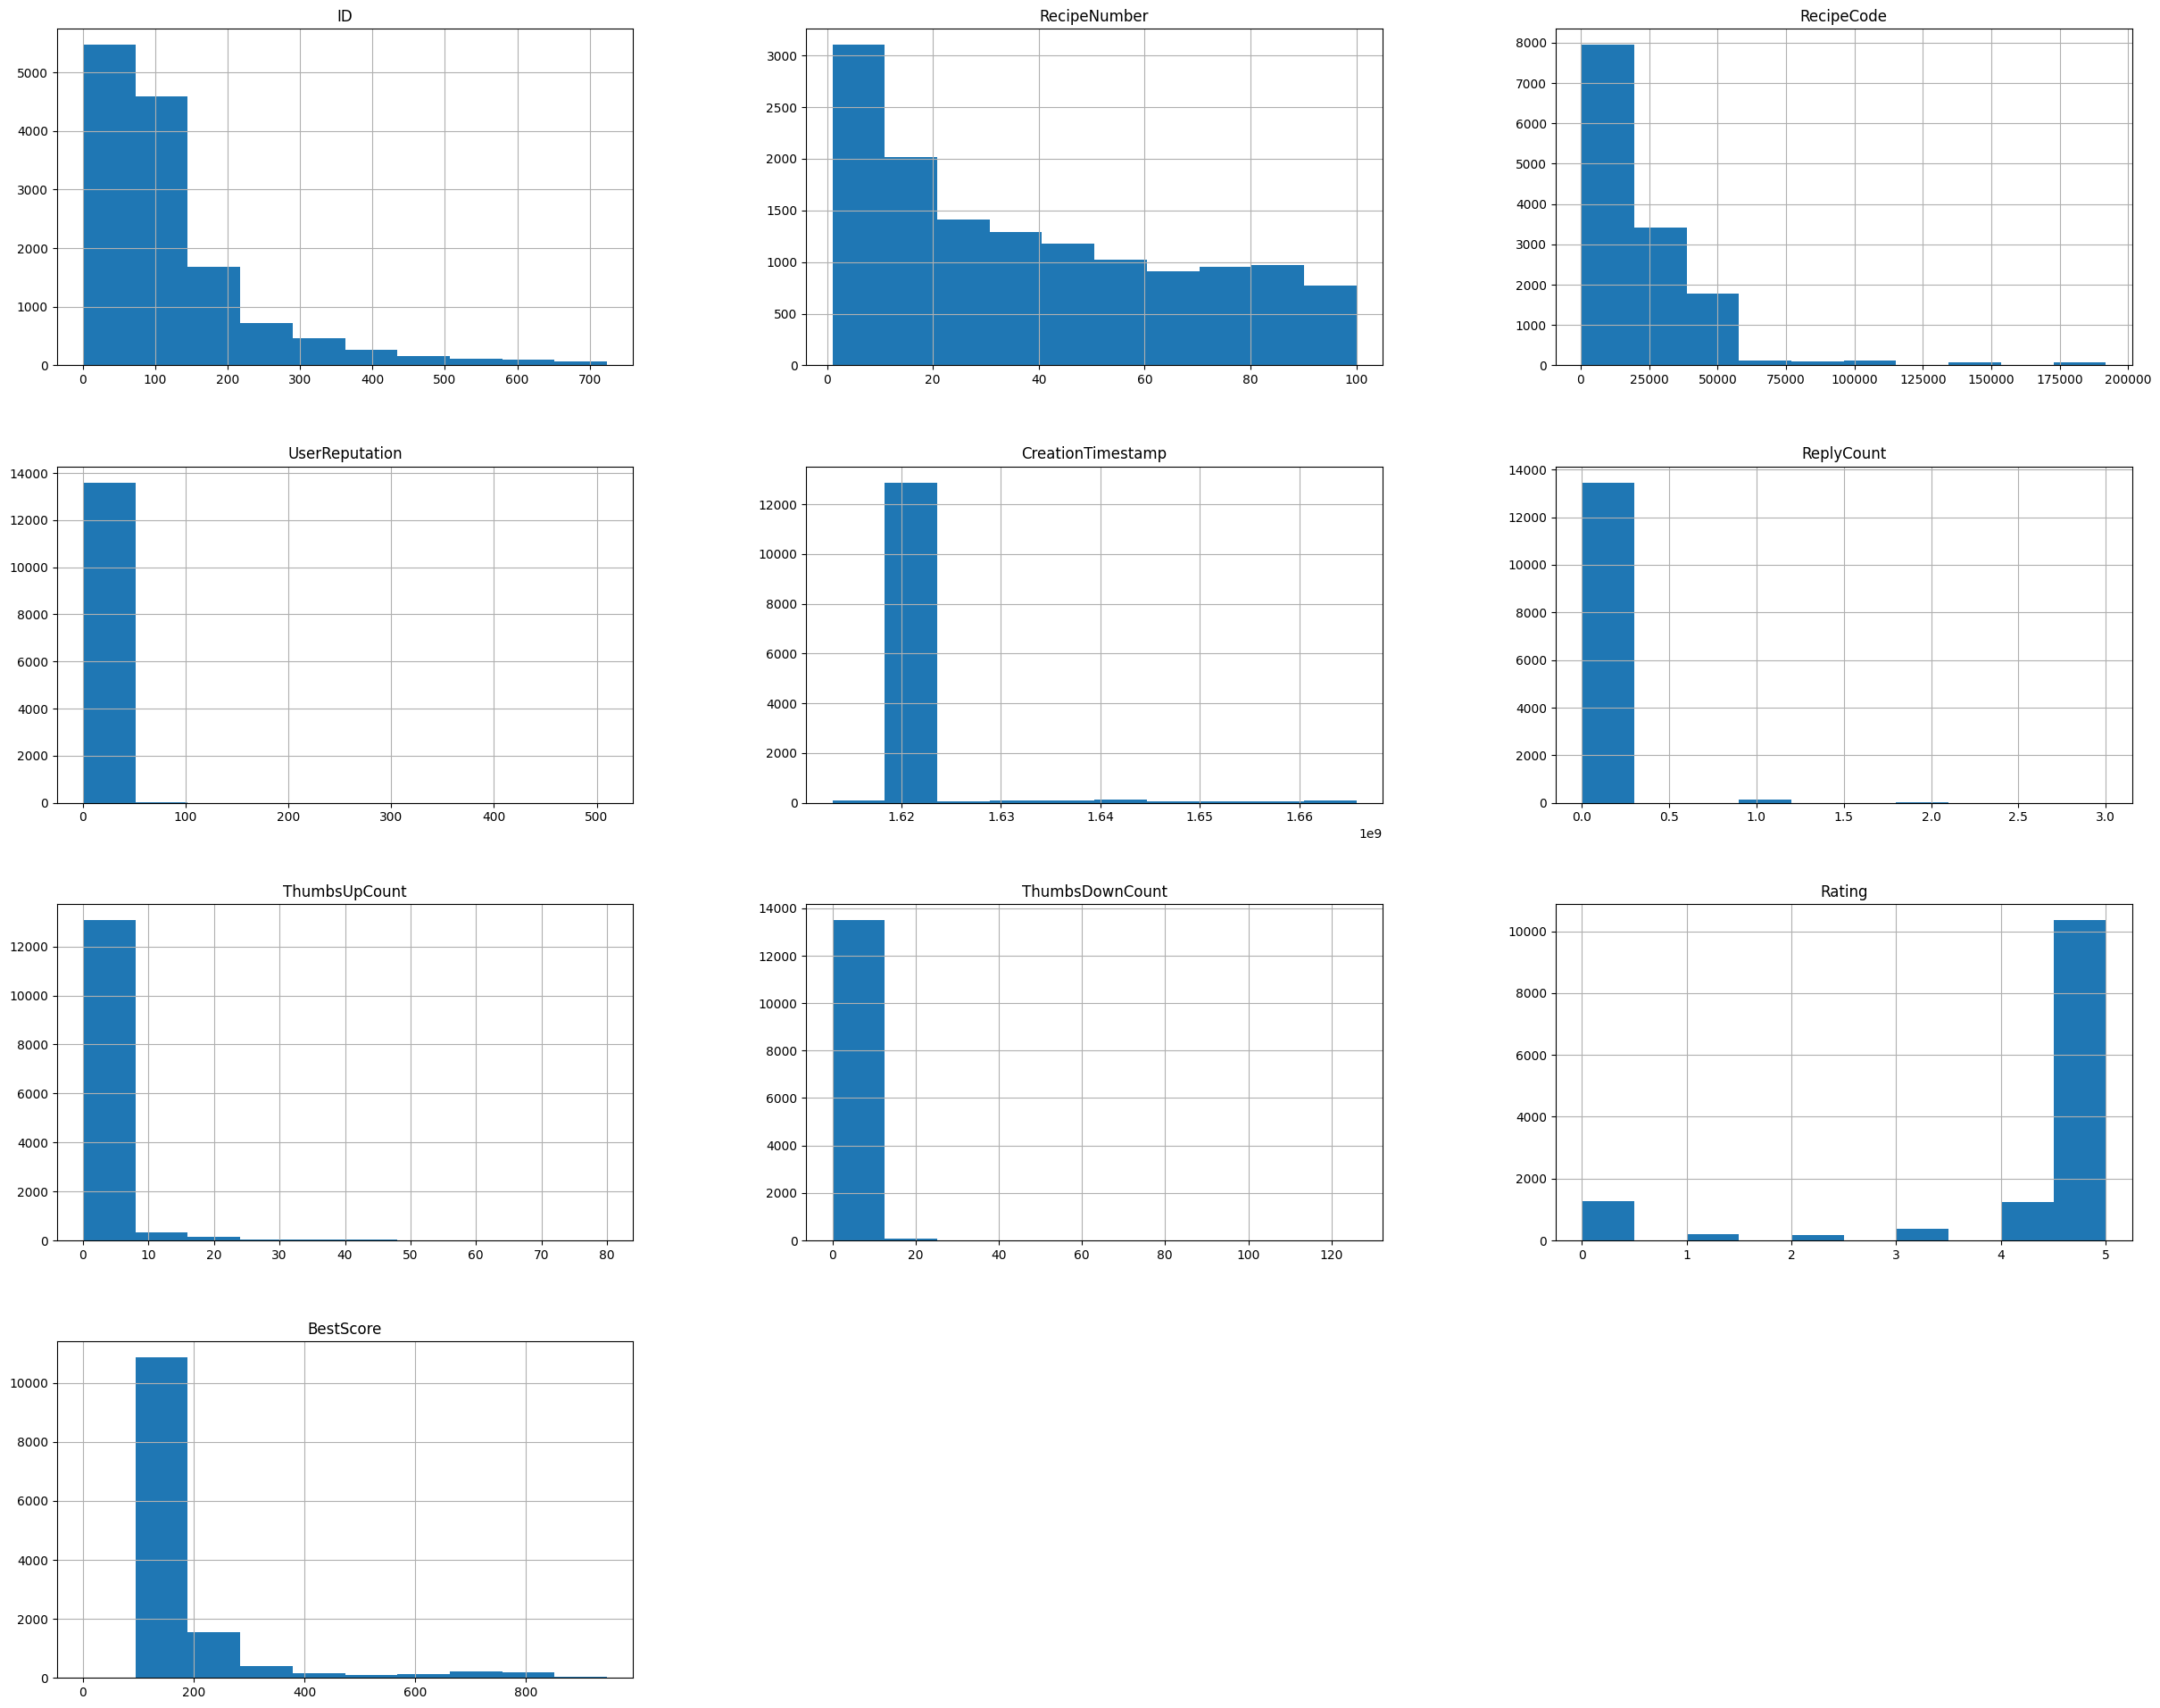

In [7]:
#plotting histogram for each column in the dataset.
train_df.hist(figsize=(30,24))

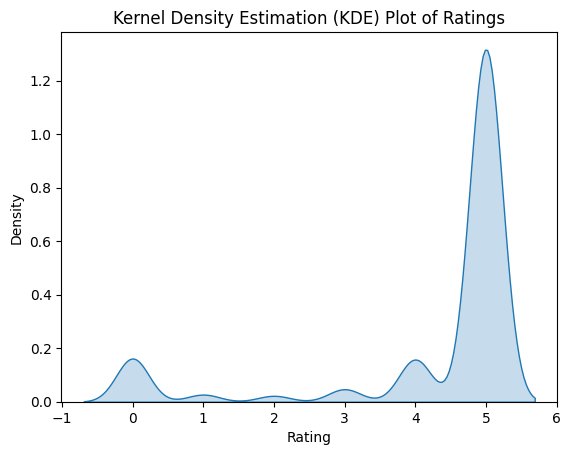

In [8]:
# Plotting KDE plot for target variable(Rating)
sns.kdeplot(train_df["Rating"], fill=True)
plt.title('Kernel Density Estimation (KDE) Plot of Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()

In [9]:
#count the instance of majority class in the train data.
print("% of instance belonging to majority class is :",round((len(train_df[train_df["Rating"]==5])/len(train_df))*100))

% of instance belonging to majority class is : 76


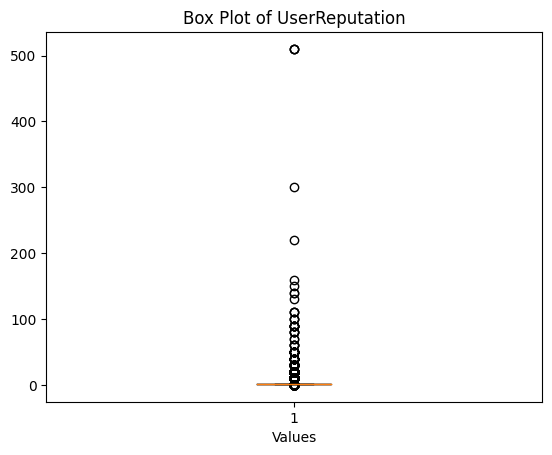

In [10]:
#plotting Box Plot for UserReputation column
plt.boxplot(train_df['UserReputation'])
plt.title('Box Plot of ' + 'UserReputation')
plt.xlabel('Values')
plt.show()


<Axes: >

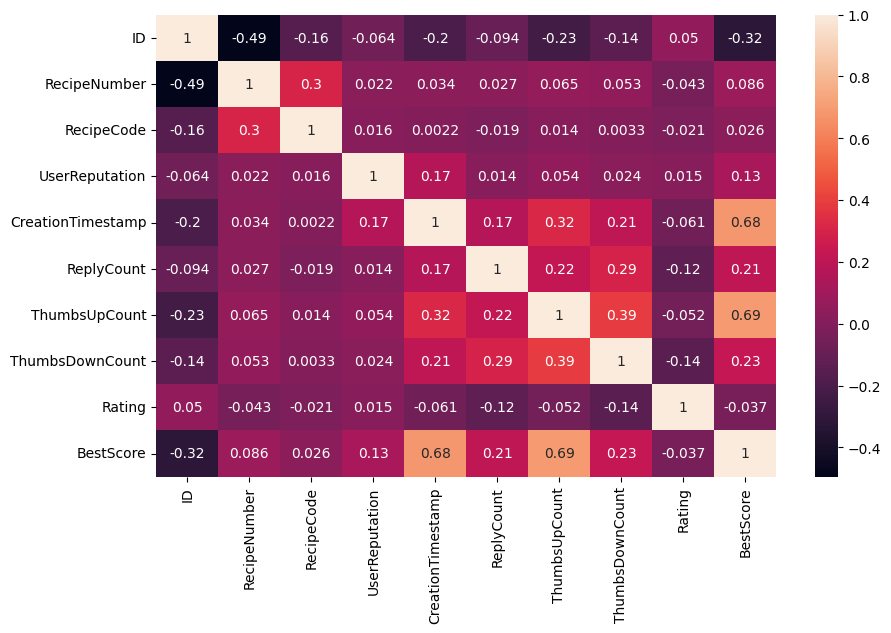

In [11]:
#CORRELATION MATRIX OF DATA
numeric = train_df.select_dtypes(include=['int64']).columns
corr_matrix = train_df[numeric].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot= True)

In [12]:
#Checking for Missing Values in Dataset
train_df.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

**KEY FINDINGS**
* Dataset contains 2 missing values present in Recipe_Review column.
* None of the numeric feature shows strong positive or negative correlation with the Target variable by looking at the Correlation heatmap.
* Box plot for UserReputaion shows possible outliers.
* Dataset is highly imbalanced; about 76% of data belongs to the same majority class.
* Rating has 1272 (9.3%) zeros
 



# **DATA PREPROCESSING & FEATURE ENGINEERING**

**DEALING WITH OUTLIERS**

In [13]:
#Detecting and removing Outliers

from scipy import stats
# Calculate z-scores for the column
z_scores = np.abs(stats.zscore(train_df['UserReputation']))

# Define threshold for identifying outliers
threshold = 10

# Find indices of outliers
outlier_indices = np.where(z_scores > threshold)[0]

# Get the actual values of outliers
outliers = train_df["UserReputation"].iloc[outlier_indices]

print("Outliers :\n", outliers)

# Remove outliers from train_df
train_df_cleaned = train_df.drop(outlier_indices)

Outliers :
 319      160
663      510
1646     140
2381     220
2681     140
3423     110
6254     130
7610     150
8218     110
10631    110
10647    510
11161    300
13364    510
Name: UserReputation, dtype: int64


**DEALING WITH MISSING VALUES IN DATAFRAME**

In [14]:
#imputing the missing value in Recipe_Review column using the strategy = mode

train_df_cleaned['Recipe_Review'].fillna(train_df_cleaned['Recipe_Review'].mode()[0], inplace=True)
train_df_cleaned.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        0
dtype: int64

**CREATING NEW FEATURES (DAY, MONTH, YEAR) FROM TIMESTAMP COLUMN**

In [15]:
# Convert timestamp to datetime
df = train_df_cleaned.copy()
df['datetime'] = pd.to_datetime(df['CreationTimestamp'], unit='s')

# Extract date, month, and year into separate columns
df['date'] = df['datetime'].dt.day.astype(int)
df['month'] = df['datetime'].dt.month.astype(int)
df['year'] = df['datetime'].dt.year.astype(int)


df = df.drop(columns =['CreationTimestamp','datetime'], axis = 1)
df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,date,month,year
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,0,0,0,5,100,great recipe! I have made them just as written...,3,6,2021
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,0,0,1,5,100,This is an easy and quick recipe that is great...,3,6,2021
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,0,0,0,3,100,I think I was looking for something extra spec...,3,6,2021
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,2,6,2021
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,3,6,2021


In [16]:
# Define a function to map months to quarters
def get_quarter(month):
    if month in range(1, 4):
        return 1
    elif month in range(4, 7):
        return 2
    elif month in range(7, 10):
        return 3
    else:
        return 4

# Apply the function to create the 'quarter_of_year' column
df['quarter_of_year'] = df['month'].apply(get_quarter)

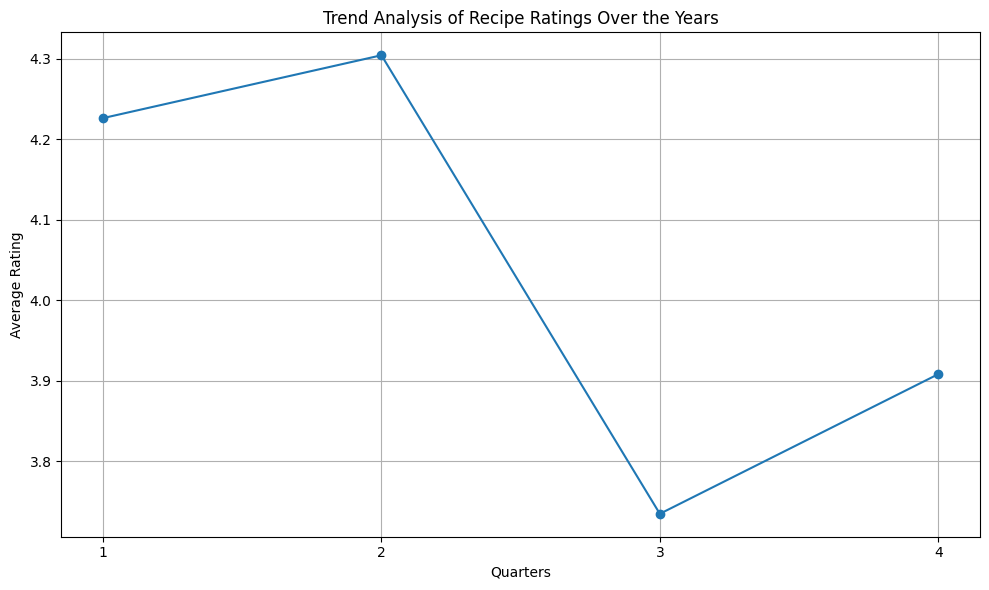

In [17]:
# Calculate average rating for each Quarter
avg_rating_year = df.groupby('quarter_of_year')['Rating'].mean()

# Plotting the trend analysis graph
plt.figure(figsize=(10, 6))
plt.plot(avg_rating_year.index, avg_rating_year.values, marker='o', linestyle='-')
plt.title('Trend Analysis of Recipe Ratings Over the Years')
plt.xlabel('Quarters')
plt.ylabel('Average Rating')
plt.grid(True)
plt.xticks(avg_rating_year.index)
plt.tight_layout()
plt.show()

**DEALING WITH TEXT COLUMN : CLEANING RECIPE_REVIEW COLUMN**

In [18]:
#Defining Stop Words

STOP_WORDS = {"i", "im", "ive", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"}

# Define the emoji detection pattern
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251" 
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u200d"
                           u"\u2640-\U0001F251" 
                           u"\u2600-\u2B55"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\u3030"
                           "]+", flags=re.UNICODE)

def clean(s):
    # Step 1: Make the text lowercase
    s = str(s).lower()
    
    # Step 2: Remove punctuation
    PUNCT_TO_REMOVE = string.punctuation
    s = s.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    
    # Step 3: Remove numbers
    s = ''.join([i for i in s if not i.isdigit()])
    
    # Step 4: Remove HTML encoding for apostrophe character (')
    s = html.unescape(s)
    
    # Step 5: Remove extra space
    s = " ".join(s.split())
    
    # Step 6: Replace 'amp;' with 'and'
    s = s.replace('amp', 'and')
    
    # Step 7: Remove URLs
    # Step 7: Remove words containing "www" and "http"
    #s = re.sub(r'\b\w*(http|www)\w*\b', '', s)
    
    # Step 7: Remove emojis
    s = emoji_pattern.sub(r'', s)
    
    # Step 8: Remove stop words
    s = ' '.join([word for word in s.split() if word not in STOP_WORDS])

    return s

#applying the above defined function on the dataframe
train_df_cleaned["Recipe_Review"] = train_df_cleaned["Recipe_Review"].apply(clean)

**CREATING WORD CLOUD FOR CLEANED TEXT DATA**

In [19]:
'''from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'train_df' is your DataFrame containing the 'UserReview' column
# Replace 'train_df' with your actual DataFrame variable name

# Concatenate all text data in the 'UserReview' column into a single string
text_data = ' '.join(train_df_cleaned['Recipe_Review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()'''


"from wordcloud import WordCloud\nimport matplotlib.pyplot as plt\n\n# Assuming 'train_df' is your DataFrame containing the 'UserReview' column\n# Replace 'train_df' with your actual DataFrame variable name\n\n# Concatenate all text data in the 'UserReview' column into a single string\ntext_data = ' '.join(train_df_cleaned['Recipe_Review'])\n\n# Create a WordCloud object\nwordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)\n\n# Plot the WordCloud\nplt.figure(figsize=(10, 8))\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')  # Turn off axis\nplt.show()"

**SEPARATING TARGET COLUMN FROM DATASET**

In [20]:
#SEPARATING TARGET COLUMN FROM DATASET AND DROPPING UNNCECESSARY COLUMNS
X = train_df_cleaned.drop(columns=["Rating"], axis = 1)
y = train_df_cleaned["Rating"]

***SPLITTING THE DATA INTO TRAIN AND VALIDATION SET***

In [21]:
#splitting the data into train and validation set using Sklearn train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#valaidating if the split happened correctly
print(X_train.shape[0]==y_train.shape[0])
print(X_test.shape[0]==y_test.shape[0])

True
True


**DEFINING PREPROCESSOR**

In [22]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

# Define a pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_cols', 'drop', ['ID','RecipeName', 'CommentID', 'UserID', 'UserName', 'ReplyCount']),  # Drop unnecessary columns
        #('num', StandardScaler(), ['RecipeNumber',"RecipeCode", 'UserReputation','CreationTimestamp','ThumbsUpCount','ThumbsDownCount','BestScore']),
        ('text', TfidfVectorizer(max_features=800, stop_words='english'), 'Recipe_Review')
    ],
    remainder='passthrough'
)



# **MODEL BUILDING & TRAINING & TESTING THE MODEL**

In [23]:
#DEFINING A DICTIONARY TO COLLECT ACCURACY SCORE OF THE VARIOUS MODELS
accuracy_scores = {}

**FITTING BASELINE DUMMY CLASSIFIER ON RAW DATA**

In [24]:
'''#using DummyClassifier for predicting the ratings
model = DummyClassifier(strategy = "most_frequent")
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

accuracy_scores["DummyClassifier"] = accuracy'''

'#using DummyClassifier for predicting the ratings\nmodel = DummyClassifier(strategy = "most_frequent")\nmodel.fit(X_train,y_train)\ny_pred = model.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\naccuracy_scores["DummyClassifier"] = accuracy'

**MODEL 1 - LOGISTIC REGRESSION WITH CROSS VALIDATION AND HYPERPARAMETER TUNING**

In [25]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# Define the hyperparameter grid
param_grid = {
    'model__C': [0.1, 1, 10],  # Regularization parameter
    'model__penalty': ['l2'],  # Penalty norm
}

# Define the model
model = LogisticRegression(max_iter=1000)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Create GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Store accuracy score
accuracy_scores["LogisticRegression"] = accuracy'''

'from sklearn.model_selection import GridSearchCV\nfrom sklearn.linear_model import LogisticRegression\n\n\n# Define the hyperparameter grid\nparam_grid = {\n    \'model__C\': [0.1, 1, 10],  # Regularization parameter\n    \'model__penalty\': [\'l2\'],  # Penalty norm\n}\n\n# Define the model\nmodel = LogisticRegression(max_iter=1000)\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', model)\n])\n\n# Create GridSearchCV\ngrid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=\'accuracy\')\n\n# Fit GridSearchCV\ngrid_search.fit(X_train, y_train)\n\n# Get the best model\nbest_model = grid_search.best_estimator_\n\n# Make predictions\ny_pred = best_model.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\n# Store accuracy score\naccuracy_scores["LogisticRegression"] = accuracy'

**MODEL 2 - RANDOMFOREST CLASSIFIER**

In [26]:
'''from sklearn.ensemble import RandomForestClassifier
# Define the model
model = RandomForestClassifier()

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

accuracy_scores["RandomForest"] = accuracy'''

'from sklearn.ensemble import RandomForestClassifier\n# Define the model\nmodel = RandomForestClassifier()\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', model)\n])\n\n# Fit the pipeline\npipeline.fit(X_train, y_train)\n\n# Make predictions\ny_pred = pipeline.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\naccuracy_scores["RandomForest"] = accuracy'

**MODEL 3 - KNN CLASSIFIER**

In [27]:
'''from sklearn.neighbors import KNeighborsClassifier

# Define the model
model = KNeighborsClassifier()

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

accuracy_scores["KNN"] = accuracy'''

'from sklearn.neighbors import KNeighborsClassifier\n\n# Define the model\nmodel = KNeighborsClassifier()\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', model)\n])\n\n# Fit the pipeline\npipeline.fit(X_train, y_train)\n\n# Make predictions\ny_pred = pipeline.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\naccuracy_scores["KNN"] = accuracy'

**MODEL 4 - SVM Classifier**

In [28]:
'''from sklearn.svm import SVC
# Define the model
model = SVC(kernel='rbf', random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

accuracy_scores["SVM Classifer"] = accuracy'''

'from sklearn.svm import SVC\n# Define the model\nmodel = SVC(kernel=\'rbf\', random_state=42)\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', model)\n])\n\n# Fit the pipeline\npipeline.fit(X_train, y_train)\n\n# Make predictions\ny_pred = pipeline.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\naccuracy_scores["SVM Classifer"] = accuracy'

**MODEL 5 - BAGGING CLASSIFIER WITH RANDOMFOREST AS BASE MODEL**

In [29]:
'''from sklearn.ensemble import BaggingClassifier

# Define the base model
base_model = RandomForestClassifier()  # or any other classifier of your choice

# Define the Bagging Classifier with the base model
model = BaggingClassifier(base_model)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

accuracy_scores["BaggingClassifier"] = accuracy'''

'from sklearn.ensemble import BaggingClassifier\n\n# Define the base model\nbase_model = RandomForestClassifier()  # or any other classifier of your choice\n\n# Define the Bagging Classifier with the base model\nmodel = BaggingClassifier(base_model)\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', model)\n])\n\n# Fit the pipeline\npipeline.fit(X_train, y_train)\n\n# Make predictions\ny_pred = pipeline.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\naccuracy_scores["BaggingClassifier"] = accuracy'

**MODEL 6 -  LGBM CLASSIFIER**

In [30]:
'''from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

accuracy_scores["LGBM Classifier"] = accuracy'''

'from lightgbm import LGBMClassifier\n\n# Define the model\nmodel = LGBMClassifier(random_state=42)\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', model)\n])\n\n# Fit the pipeline\npipeline.fit(X_train, y_train)\n\n# Make predictions\ny_pred = pipeline.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\naccuracy_scores["LGBM Classifier"] = accuracy'

# **HYPERPARAMETER TUNING FOR LGBM CLASSIFIER**

In [31]:
'''from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
model = LGBMClassifier(random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', model)
])

param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [-1, 3, 5],
    'clf__num_leaves': [20, 30, 31, 40],
    'clf__min_child_samples': [20, 50]
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters found:")
print(grid_search.best_params_)'''

'from lightgbm import LGBMClassifier\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the model\nmodel = LGBMClassifier(random_state=42)\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'clf\', model)\n])\n\nparam_grid = {\n    \'clf__n_estimators\': [50, 100, 200],\n    \'clf__learning_rate\': [0.01, 0.1, 0.2],\n    \'clf__max_depth\': [-1, 3, 5],\n    \'clf__num_leaves\': [20, 30, 31, 40],\n    \'clf__min_child_samples\': [20, 50]\n}\n\n# Perform GridSearchCV\ngrid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\n# Print best parameters\nprint("Best parameters found:")\nprint(grid_search.best_params_)'

**Best parameters found:
{'clf__learning_rate': 0.1, 'clf__max_depth': -1, 'clf__min_child_samples': 20, 'clf__n_estimators': 100, 'clf__num_leaves': 40**

**LGBM WITH HYPERPARAMETERS**

In [32]:
'''from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(learning_rate = 0.1, max_depth= -1, min_child_samples = 20, n_estimators = 100, num_leaves = 40,random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

accuracy_scores["LGBM_HPT Classifier"] = accuracy'''

'from lightgbm import LGBMClassifier\n\n# Define the model\nmodel = LGBMClassifier(learning_rate = 0.1, max_depth= -1, min_child_samples = 20, n_estimators = 100, num_leaves = 40,random_state=42)\n\n# Create a pipeline\npipeline = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', model)\n])\n\n# Fit the pipeline\npipeline.fit(X_train, y_train)\n\n# Make predictions\ny_pred = pipeline.predict(X_test)\n\n# Calculate accuracy score\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy:", accuracy)\n\naccuracy_scores["LGBM_HPT Classifier"] = accuracy'

**ACCURACY SCORE FOR EACH MODELS**
*  'DummyClassifier': 0.7486238532110092,
*  'LogisticRegression': 0.7625688073394495,
*  'RandomForest': 0.7640366972477064,
*  'SVM Classifer': 0.7508256880733944,
*  'KNN': 0.7295412844036697,
*  'BaggingClassifier': 0.756697247706422,
*  'LGBM Classifier': 0.7728440366972477

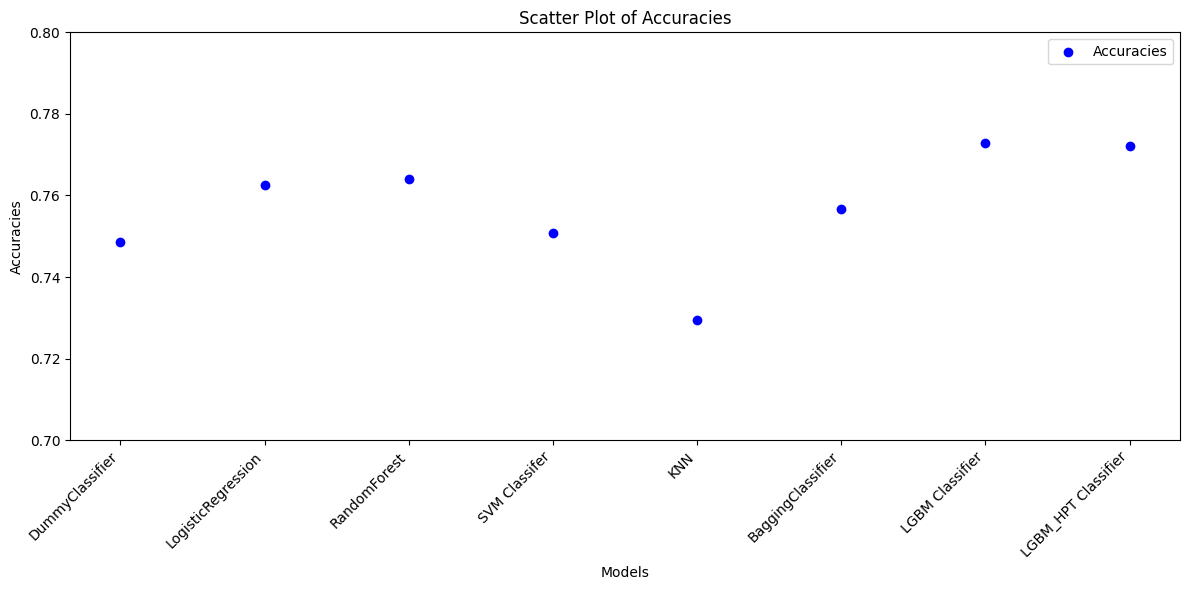

In [33]:
Accuracies = {'DummyClassifier': 0.7486238532110092,
             'LogisticRegression': 0.7625688073394495,
             'RandomForest': 0.7640366972477064,
             'SVM Classifer': 0.7508256880733944,
             'KNN': 0.7295412844036697,
             'BaggingClassifier': 0.756697247706422,
             'LGBM Classifier': 0.7728440366972477,
             'LGBM_HPT Classifier' : 0.7721100917431193}

plt.figure(figsize=(12, 6))
plt.scatter(list(Accuracies.keys()), list(Accuracies.values()), label='Accuracies', marker='o', color='blue')
plt.ylim(0.70, 0.80)
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.title('Scatter Plot of Accuracies')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


**PLOTTING CLASS-SPECIFIC PERFORMANCE CURVE**

In [34]:
'''from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y_test contains the true labels and y_score contains the predicted probabilities for each class
y_score = pipeline.predict_proba(X_test)

# Compute precision-recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(model.classes_)):
    precision[i], recall[i], _ = precision_recall_curve(y_test == model.classes_[i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test == model.classes_[i], y_score[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(recall[i], precision[i], lw=2, label='Precision-recall curve (class %d, AP = %0.2f)' % (i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class-Specific Precision-Recall Curve')
plt.legend(loc="best")
plt.show()'''


'from sklearn.metrics import precision_recall_curve, average_precision_score\nimport matplotlib.pyplot as plt\n\n# Assuming y_test contains the true labels and y_score contains the predicted probabilities for each class\ny_score = pipeline.predict_proba(X_test)\n\n# Compute precision-recall curve and area for each class\nprecision = dict()\nrecall = dict()\naverage_precision = dict()\nfor i in range(len(model.classes_)):\n    precision[i], recall[i], _ = precision_recall_curve(y_test == model.classes_[i], y_score[:, i])\n    average_precision[i] = average_precision_score(y_test == model.classes_[i], y_score[:, i])\n\n# Plot precision-recall curve for each class\nplt.figure(figsize=(8, 6))\nfor i in range(len(model.classes_)):\n    plt.plot(recall[i], precision[i], lw=2, label=\'Precision-recall curve (class %d, AP = %0.2f)\' % (i, average_precision[i]))\n\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Class-Specific Precision-Recall Curve\')\nplt.legend(loc="best")\npl

**PLOTTING CONFUSION MATRIX**

In [35]:
'''from sklearn.metrics import confusion_matrix

# Define class labels (ratings from 0 to 5)
class_labels = [str(i) for i in range(6)]
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust font scale
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()'''

"from sklearn.metrics import confusion_matrix\n\n# Define class labels (ratings from 0 to 5)\nclass_labels = [str(i) for i in range(6)]\n# Compute confusion matrix\ncm = confusion_matrix(y_test, y_pred)\n\n# Plot confusion matrix\nplt.figure(figsize=(8, 6))\nsns.set(font_scale=1.4)  # Adjust font scale\nsns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,\n            xticklabels=class_labels,\n            yticklabels=class_labels)\nplt.xlabel('Predicted labels')\nplt.ylabel('True labels')\nplt.title('Confusion Matrix')\nplt.show()"

# INSIGHTS FROM THE MODEL
* **AMONG ALL THESE MODELS, LGBM_CLASSIFIER PERFORMED BEST**
* **MODEL IS PERFORMING WELL AT CLASSIFYING MAJORITY CLASS BUT FAILS TO PREDICT MINORITY CLASSES**
* **FINALLY WE WILL USE LGBM CLASSIFIER ON TEST DATA WHICH WAS UNSEEN TO FIND ACCURACY SCORE ON KAGGLE**

In [36]:
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier()
# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline
pipeline.fit(X, y)

# Make predictions
y_pred = pipeline.predict(test_df)


In [37]:
y_pred[:5]

array([5, 5, 0, 4, 5])

In [38]:
#saving predited data into csv
submission = pd.DataFrame({"ID" : range(1,4547),
                           "Rating" : y_pred})
submission.to_csv("submission.csv", index = False)